# Titanic Analysis
(Cloud & Cognitive Services project)

## Task
Create a model that predicts which passengers survived the Titanic shipwreck <br>
Steps:
- Perform Exploratory Data Analysis to understand your data
- Perform data cleaning (missing, wrong data?)
- Consider at least 3 classifications algorithms (and think to the corresponding Spark pipelines) and perform hyperparameter tuning 
- Compare the best models

Download only with the “training set” and perform 80-20 split to obtain your train and test set

## Colab Env
Run this code if you're using Colab

In [0]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive/MyDrive/BABD/CCS/project #change it with your path

In [0]:
#!pip install pyspark

In [0]:
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName("ProjectAnalysis").getOrCreate()

## Libraries

In [0]:
from pyspark.sql.functions import col, isnan, when, count, desc, udf, regexp_extract, expr, sum as spark_sum
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

## Data
https://www.kaggle.com/c/titanic/overview

In [0]:
df = spark.read \
    .format("csv") \
    .option("inferSchema", "false") \
    .option("header", "true") \
    .option("sep", ",") \
    .load("/FileStore/tables/titanic_train.csv")

In [0]:
df.display()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,null,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,null,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,null,S
6,0,3,"Moran, Mr. James",male,null,0,0,330877,8.4583,null,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,null,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,null,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,null,C


## 1) EDA

### 1.1) Data overview

In [0]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



For sake of simplicity we cast some columns from string to numerical

In [0]:
df = df\
    .withColumn("PassengerId", col("PassengerId").cast(IntegerType()))\
    .withColumn("Survived", col("Survived").cast(IntegerType()))\
    .withColumn("Pclass", col("Pclass").cast(IntegerType()))\
    .withColumn("Age", col("Age").cast(IntegerType()))\
    .withColumn("SibSp", col("SibSp").cast(IntegerType()))\
    .withColumn("Parch", col("Parch").cast(IntegerType()))\
    .withColumn("Fare", col("Fare").cast(DoubleType()))

In [0]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



- PassengerId: An identifier for each passenger.
- Survived: Survival status of the passenger
  - 1 = yes
  - 0 = no
- Pclass: Ticket class as a proxy for socio-economic status
  - 1 = 1st, 
  - 2 = 2nd, 
  - 3 = 3rd
- Name: Full name of the passenger.
- Sex: Male or female.
- Age: Age in years.
- SibSp: Number of siblings/spouses aboard.
- Parch: Number of parents/children aboard.
- Ticket: Ticket number.
- Fare: Passenger fare.
- Cabin: Cabin number.
- Embarked: Port of embarkation 
  - C = Cherbourg, 
  - Q = Queenstown, 
  - S = Southampton

In [0]:
print("rows:", df.count())
print("columns:", len(df.columns))

rows: 891
columns: 12


### 1.2) Statistical summary (before cleaning)

In [0]:
df.describe().display()

summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,891,891,714,891,891,891,891,204,889
mean,446.0,0.3838383838383838,2.308641975308642,null,null,29.679271708683473,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,null,null
stddev,257.3538420152301,0.4865924542648585,0.8360712409770513,null,null,14.536482769437558,1.1027434322934275,0.8060572211299559,471609.26868834946,49.6934285971809,null,null
min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0,0,0,110152,0.0,A10,C
max,891,1,3,"van Melkebeke, Mr. Philemon",male,80,8,6,WE/P 5735,512.3292,T,S


### 1.3) Duplicate values

In [0]:
duplicates = df.count() - (df.dropDuplicates()).count()
print(f"Number of duplicate rows: {duplicates}")

# display the duplicate rows
if duplicates > 0:
    from pyspark.sql.functions import col
    # Columns to check for duplicates, if you want to specify: ['column1', 'column2']
    df.groupBy(df.columns).count().filter(col('count') > 1).drop('count').show()

Number of duplicate rows: 0


### 1.4) Missing values

In [0]:
missing_data = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_data.display()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,177,0,0,0,0,687,2


Missing values for:
- Age (177 missing values)
- Cabin (687 missing values)
- Embarked (2 missing values)

#### 1.4.1) Managing "Age" missing values

Options:
- drop rows with missing values
- knn
- title + mean/median (https://www.kaggle.com/code/ylt0609/3-strategies-analyzing-age-and-their-impact)
- sara/jade idea -> regression

The following code explains the third option

In [0]:
# get the title from 'Name' column
df = df.withColumn("Title", regexp_extract("Name", "([A-Za-z]+)\.", 1))
#df.display()

In [0]:
title_count = df.groupBy("Title").count()
title_count.display()

Title,count
Don,1
Miss,182
Countess,1
Col,2
Rev,6
Lady,1
Master,40
Mme,1
Capt,1
Mr,517


Let's fix wierd titles like Mlle, Mme ect!

In [0]:
replacement_dict = {
    'Mlle': 'Miss',
    'Mme': 'Miss',
    'Ms': 'Miss',
    'Dr': 'Mr',
    'Major': 'Mr',
    'Lady': 'Mrs',
    'Countess': 'Mrs',
    'Jonkheer': 'Other',
    'Col': 'Other',
    'Rev': 'Other',
    'Capt': 'Mr',
    'Sir': 'Mr',
    'Don': 'Mr'
}

# Replace values in the 'Title' column
for old_value, new_value in replacement_dict.items():
    df = df.withColumn("Title", when(df["Title"] == old_value, new_value).otherwise(df["Title"]))

df.display()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,null,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,null,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,null,S,Mr
6,0,3,"Moran, Mr. James",male,null,0,0,330877,8.4583,null,Q,Mr
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,Mr
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,null,S,Master
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,null,S,Mrs
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,null,C,Mrs


In [0]:
average_age_by_title = df.groupBy("Title").agg(F.mean("Age").alias("AvgAge"))

# Join the original DataFrame with the average age DataFrame on the Title column
df_with_avg = df.join(average_age_by_title, "Title", "left")

# Replace missing values in the 'Age' column with the AvgAge where missing
df = df_with_avg.withColumn("Age", when(col("Age").isNull(), col("AvgAge")).otherwise(col("Age")))
df = df.drop("AvgAge")
df.display()

Title,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Mr,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,null,S
Mrs,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
Miss,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,null,S
Mrs,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
Mr,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,null,S
Mr,6,0,3,"Moran, Mr. James",male,32.72127139364303,0,0,330877,8.4583,null,Q
Mr,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
Master,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,null,S
Mrs,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,null,S
Mrs,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,null,C


In [0]:
# check if it worked
missing_age_count = df.filter(col('Age').isNull()).count()
print(missing_age_count)

0


#### 1.4.2) Managing "Cabin" missing values

TODO: choose an option
- convert 'Cabin' column into binary indicator
    - 0 => passenger doesn't have a cabin
    - 1 => passenger have a cabin
- cut off rows with missing values and then analise the deck (problem: too many missing values)

In [0]:
# create a new column with the binanry indicator
df = df.withColumn('Cabin2', when(col('Cabin').isNull(), 0).otherwise(1))

In [0]:
df.select('Cabin2').display()

Cabin2
0
1
0
1
0
0
1
0
0
0


In [0]:
missing_cabin_data = df.filter(col("Cabin2").isNull())
missing_cabin_data.count()

0

##### 1.4.2.1) Extracting Deck Information
Typically, cabin numbers on the Titanic are indicated by a letter followed by a number (e.g., C123). The letter usually denotes the deck, and this can be critical because the deck's proximity to the lifeboats could influence survival chances.<br>
Since the first letter of the cabin number represents the deck, you can extract this to analyze:
- New Column for Deck: Create a new column in your dataset representing the deck (extracted from the cabin's first letter). 
- Analyze by Deck: Perform statistical tests and visualizations to determine if certain decks had higher survival rates.

In [0]:
#df.select("PassengerId","Cabin").display()

In [0]:
df = df.withColumn("Deck", expr("substring(Cabin, 1, 1)"))

#### 1.4.3) Managing "Embarked" missing values

In [0]:
missing_embarked_data = df.filter(col("Embarked").isNull())
missing_embarked_data.display()

Title,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin2,Deck
Miss,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,null,1,B
Mrs,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,null,1,B


In order to overcome this issue we'll assing, to these two passangers, the most frequent value of 'Embarked' attribute.

In [0]:
frequent_embarkation = df\
    .groupby("Embarked")\
    .count()\
    .orderBy(col("count").desc())\
    .select("Embarked")\
    .first()[0]

df = df\
    .withColumn("Embarked", when(col("Embarked").isNull(), frequent_embarkation).otherwise(col("Embarked")))

In [0]:
missing_embarked_data = df.filter(col("Embarked").isNull())
missing_embarked_data.count()

0

### 1.5) Statistical summary (after cleaning)

In [0]:
df.describe().display()

summary,Title,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin2,Deck
count,891,891,891,891,891,891,891,891,891,891,891,204,891,891,204
mean,null,446.0,0.3838383838383838,2.308641975308642,null,null,29.77931803054647,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,null,null,0.22895622895622897,null
stddev,null,257.3538420152301,0.4865924542648585,0.8360712409770513,null,null,13.289951169923357,1.1027434322934275,0.8060572211299559,471609.26868834946,49.6934285971809,null,null,0.42039698906988165,null
min,Master,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.0,0,0,110152,0.0,A10,C,0,A
max,Other,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S,1,T


TODO: fix interpretation

- The average age of passengers is approximately 30 years old.
- The average fare is around 32.20.
- Passengers' ages range from 0 to 80 years.
- SibSp range from 0 to 8
- Parch range from 0 to 8
- Ticket classes, fare, and family size (siblings, spouses, parents, children) vary significantly, indicating diverse socio-economic backgrounds and family traveling situations.

### 1.6) Data visualization

In [0]:
dfp = df.toPandas()
type(dfp)

pandas.core.frame.DataFrame

In [0]:
def makeBarchart2(df, target, hue, color_palette, title, legend, label_position, xlabel, ylabel='Number of passengers'):
    if hue == None:
        ax = sns.countplot(x=target, data=df, palette=color_palette)
    else:
        ax = sns.countplot(x=target, hue=hue, data=df, palette=color_palette)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add annotations to each bar
    for p in ax.patches:
        count = int(p.get_height())
        percentage = f'{100 * count / len(df):.1f}%' if count > 0 else '0%'
        annotation_text = f'{count}\n({percentage})'  # Combined text for display
        tmp_pos=''
        if label_position=='top':
            tmp_pos=(p.get_x() + p.get_width() / 2., p.get_height())
        else:
            tmp_pos=(p.get_x() + p.get_width() / 2., 0)
        ax.annotate(
            annotation_text, 
            #(p.get_x() + p.get_width() / 2., p.get_height()), #top
            #(p.get_x() + p.get_width() / 2., p.get_height() / 2), #middle
            #(p.get_x() + p.get_width() / 2., 0), #bottom
            tmp_pos,
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color = 'black' if label_position == 'top' else 'white',
            xytext=(0, 10),
            textcoords='offset points'
        )

    if legend:
        plt.legend(title=hue)
    
    plt.show()

#### 1.6.1) Survived VS Not Survived

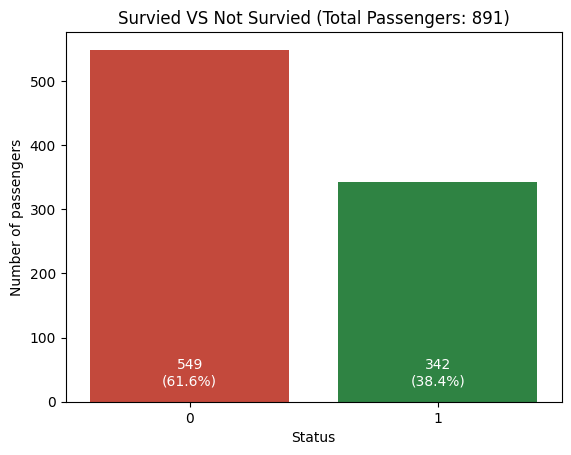

In [0]:
title = f'Survied VS Not Survied (Total Passengers: {len(dfp)})' 
makeBarchart2(dfp,'Survived',None, ['#d93725', '#21913c'], title, None, None, 'Status')

#### 1.6.2) Survived VS Not Survived splitted by gender 

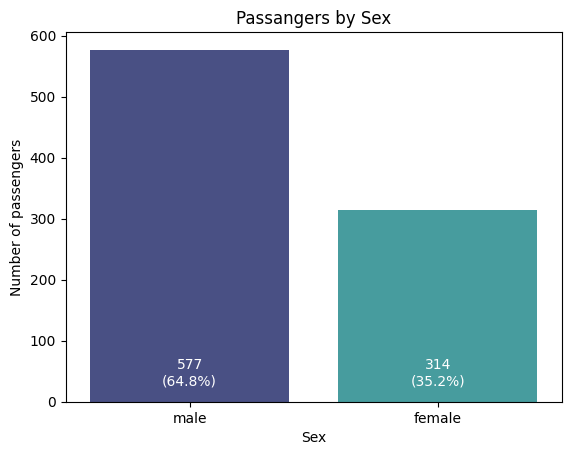

In [0]:
makeBarchart2(dfp,'Sex',None,'mako','Passangers by Sex', None, None, 'Sex')

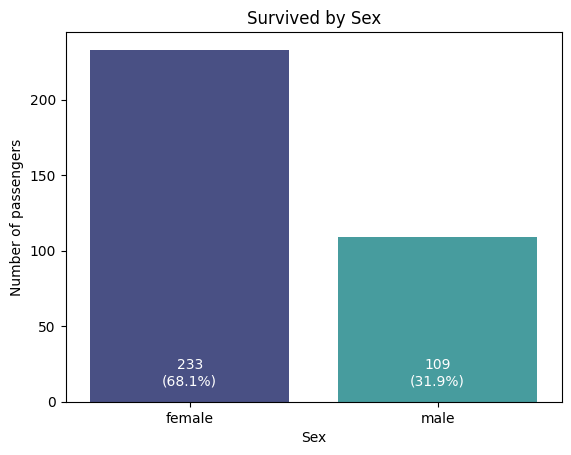

In [0]:
makeBarchart2(dfp[dfp['Survived'] == 1],'Sex',None,'mako','Survived by Sex', None, None, 'Sex')

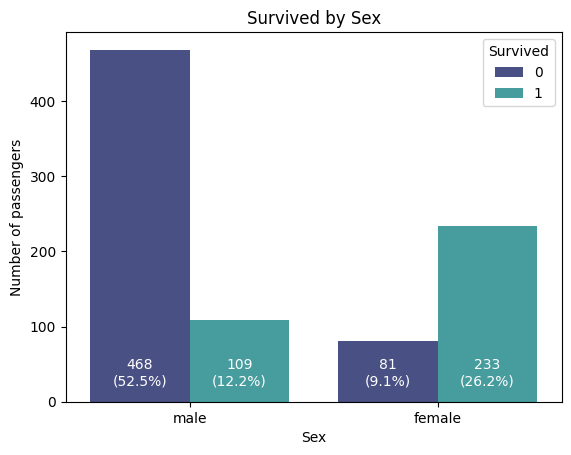

In [0]:
makeBarchart2(dfp,'Sex','Survived','mako','Survived by Sex', 'Survived', None, 'Sex') 

#### 1.6.3) Passangers Class

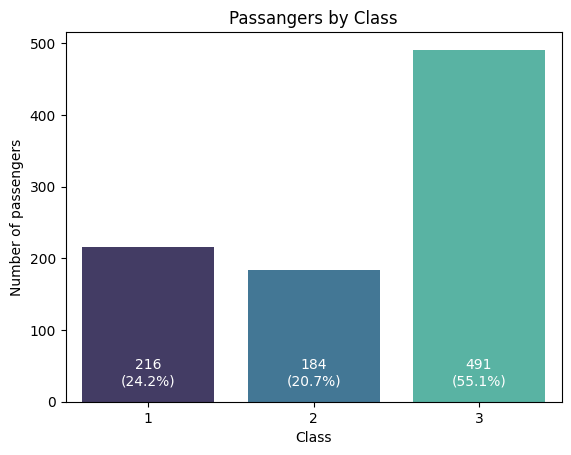

In [0]:
makeBarchart2(dfp,'Pclass',None,'mako','Passangers by Class', None, None, 'Class')

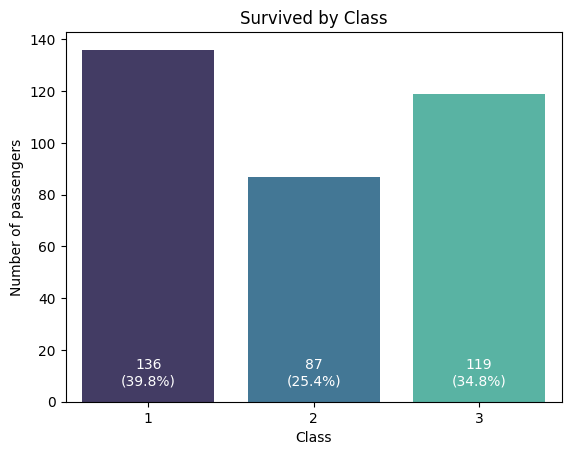

In [0]:
makeBarchart2(dfp[dfp['Survived'] == 1],'Pclass',None,'mako','Survived by Class', None, None, 'Class')

#### 1.6.4) Passangers Age

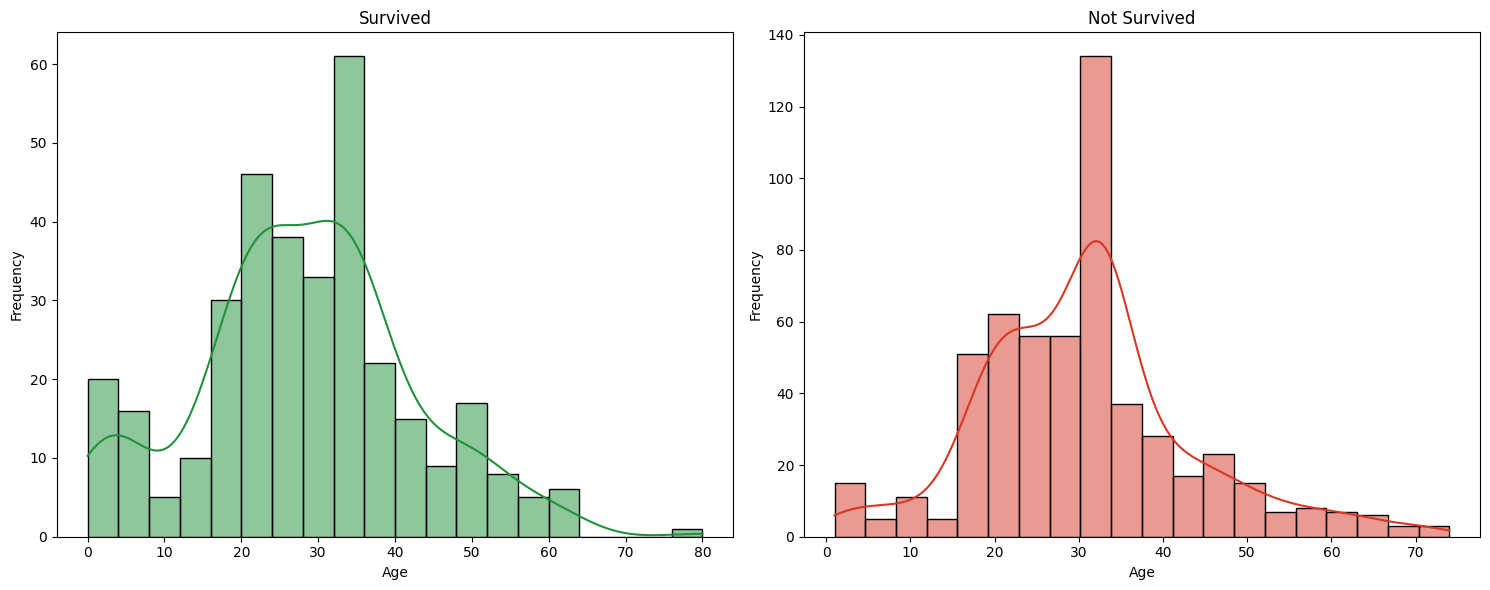

In [0]:
survived_passengers = dfp[dfp['Survived'] == 1]
not_survived_passengers = dfp[dfp['Survived'] == 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Survived plot
sns.histplot(survived_passengers['Age'], bins=20, color='#21913c', kde=True, ax=axs[0])
axs[0].set_title('Survived')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

# Not Survived plot
sns.histplot(not_survived_passengers['Age'], bins=20, color='#d93725', kde=True, ax=axs[1])
axs[1].set_title('Not Survived')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


#### 1.6.5) Port of embarkation

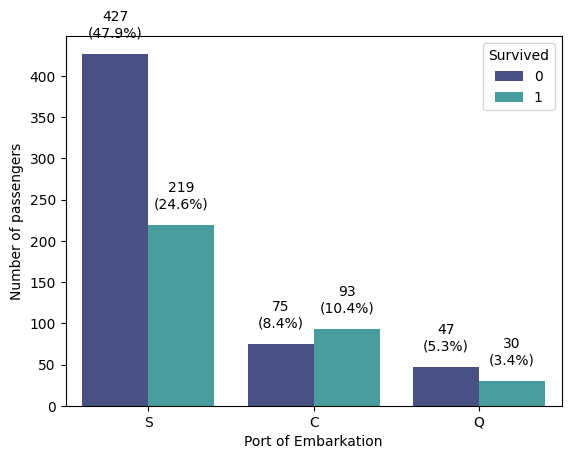

In [0]:
#makeBarchart2(dfp[dfp['Survived'] == 1],'Embarked',None,'mako','',None,'top','Port of Embarkation') #not split by gender
makeBarchart2(dfp,'Embarked','Survived','mako','','Sex','top','Port of Embarkation')

explanation

#### 1.6.6) Number of siblings/spouses aboard (SibSp)

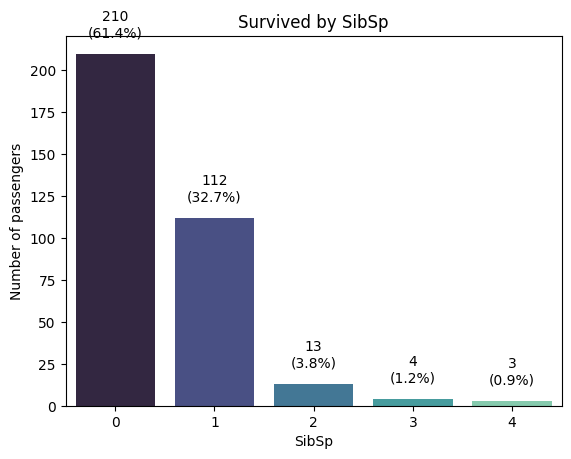

In [0]:
#makeBarchart2(dfp,'SibSp',None,'mako','Passangers by SibSp',None,'top','SibSp') #all
makeBarchart2(dfp[dfp['Survived'] == 1],'SibSp',None,'mako','Survived by SibSp',None,'top','SibSp') #survived

We can see that passengers with fewer siblings/spouses (SibSp) had a higher survival rate compared to those with more siblings/spouses. This suggests that having a smaller family size might have increased the chances of survival.

#### 1.6.7) Number of parents/children aboard

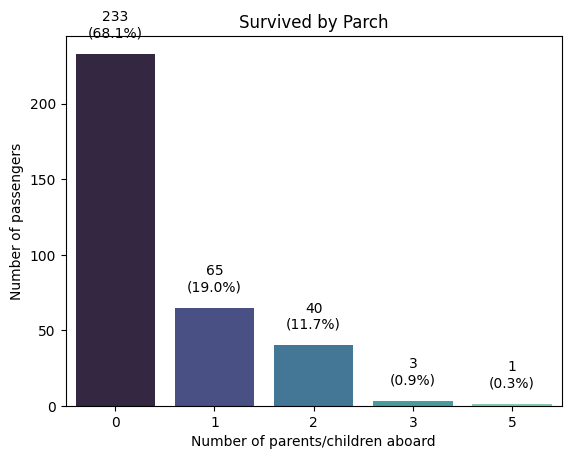

In [0]:
makeBarchart2(dfp[dfp['Survived'] == 1],'Parch',None,'mako','Survived by Parch',None,'top','Number of parents/children aboard')

#### 1.6.8) Ticket Fare

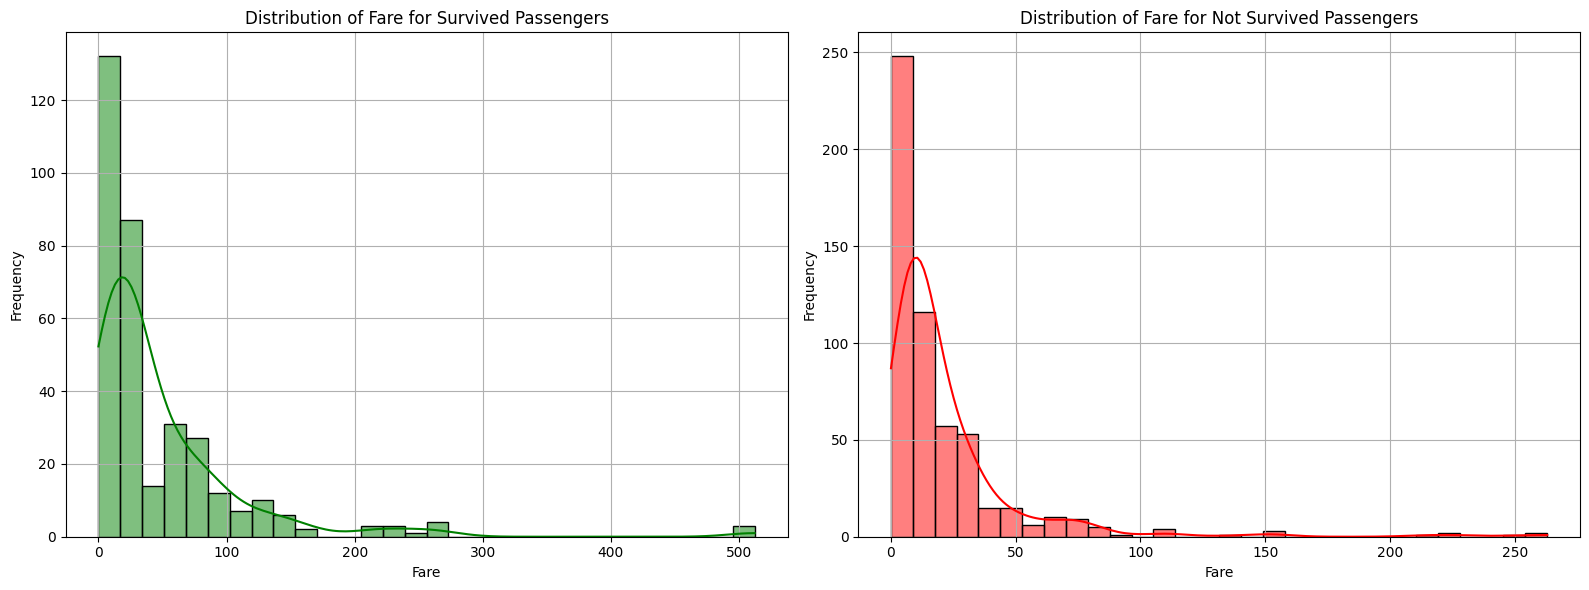

In [0]:
# Filter the DataFrame for survived and not survived passengers separately
survived_fare = dfp[dfp['Survived'] == 1]['Fare']
not_survived_fare = dfp[dfp['Survived'] == 0]['Fare']

# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting the distribution of fares for survivors
sns.histplot(survived_fare, kde=True, color='green', bins=30, ax=axes[0])
axes[0].set_title('Distribution of Fare for Survived Passengers')
axes[0].set_xlabel('Fare')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plotting the distribution of fares for non-survivors
sns.histplot(not_survived_fare, kde=True, color='red', bins=30, ax=axes[1])
axes[1].set_title('Distribution of Fare for Not Survived Passengers')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()


- Survived Plot: The distribution is right-skewed, meaning that most of the survived passengers paid lower fares, with a few paying much higher fares. This indicates that while a range of passengers across different fare levels survived, a significant proportion of survivors purchased cheaper tickets.

#### 1.6.9) Cabin
NOTE: These representation are just a test!

In [0]:
dfp = dfp[dfp['Deck'] != '0'] #drop rows with missing cabin values

Bar Chart of Deck vs. Survival: Create a bar chart showing survival rates by deck.

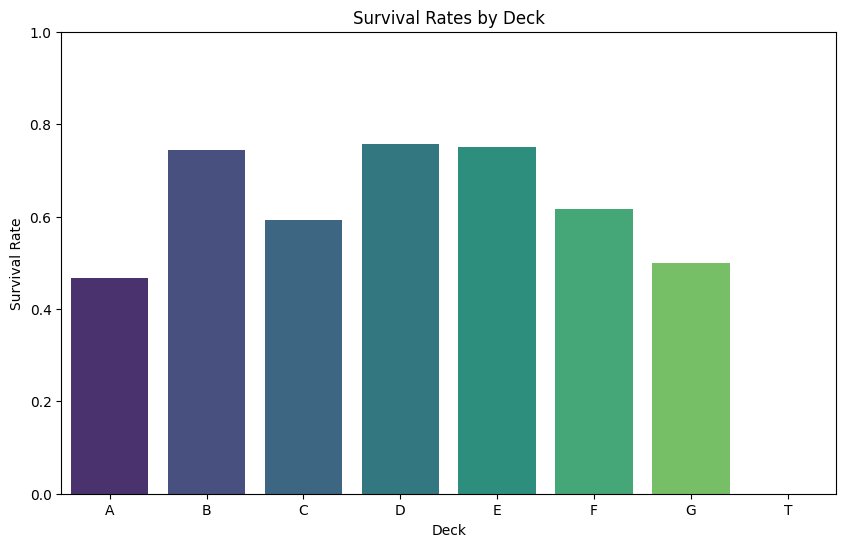

In [0]:
# Survival rates by deck
survival_by_deck = dfp.groupby('Deck')['Survived'].mean().reset_index()
survival_by_deck.columns = ['Deck', 'Survival_Rate']

# Ensure that the deck column is sorted, if necessary
survival_by_deck.sort_values('Deck', inplace=True)

# Plotting the survival rates by deck
plt.figure(figsize=(10, 6))
sns.barplot(x='Deck', y='Survival_Rate', data=survival_by_deck, palette='viridis')
plt.title('Survival Rates by Deck')
plt.xlabel('Deck')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)  # Set the y-axis limits to show proportions from 0 to 1
plt.show()

- Decks D and E show particularly high survival rates, which could suggest better access to lifeboats or more advantageous locations in case of emergency. This might indicate that passengers on these decks had a higher socio-economic status, as these areas possibly offered premium accommodations.
- Deck A has the lowest survival rate among the higher-tier decks, while Deck G and especially T have notably lower survival rates. Deck T, interestingly, shows a very low survival rate, which may indicate that this was a more isolated part of the ship, or had poorer access to emergency exits and lifeboats.
- Decks B and C show moderate survival rates. Despite likely being higher-tier accommodations (similar to A, D, and E), their survival rates aren't as high as D and E, suggesting that factors other than simply ticket class (such as cabin location relative to lifeboats) influenced survival chances.

Count Plot: Display the distribution of passengers across different decks.

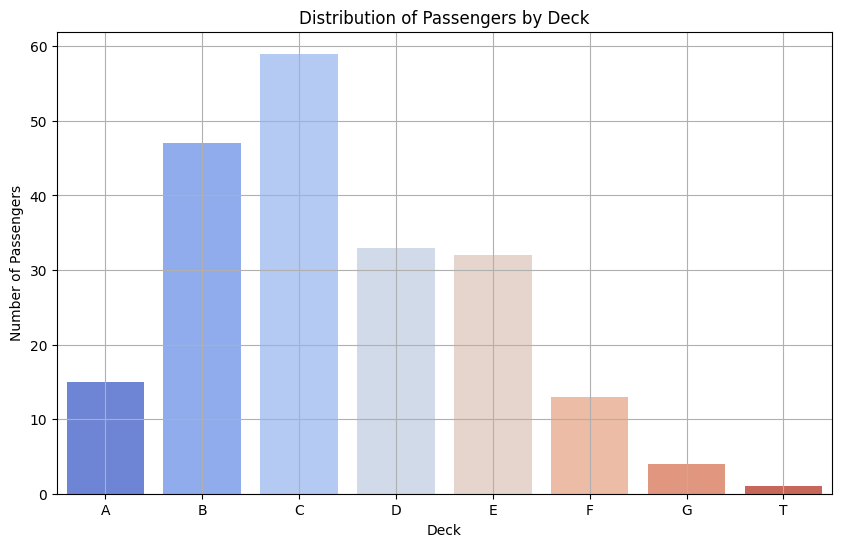

In [0]:
# Counting the number of passengers per deck
deck_counts = dfp['Deck'].value_counts().reset_index()
deck_counts.columns = ['Deck', 'Count']

# Sort the counts by Deck to ensure the plot is ordered
deck_counts.sort_values('Deck', inplace=True)

# Plotting the distribution of passengers across decks
plt.figure(figsize=(10, 6))
sns.barplot(x='Deck', y='Count', data=deck_counts, palette='coolwarm')
plt.title('Distribution of Passengers by Deck')
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

- Most Populated Decks: Decks C, B, and D had the highest number of passengers. This correlates with the survival rates to some extent where Deck D has both a high population and high survival rate, likely indicating good emergency access.
- Least Populated Decks: Deck T has very few passengers, which correlates with the very low survival rate shown. The small number of people and possibly poor location could explain their low survival probability.
- Lower Decks with Fewer People: Decks G and F have fewer passengers compared to mid and upper decks, with Deck G showing a particularly low survival rate. This suggests that, despite having fewer passengers, their chances of survival were not as high, potentially due to poorer access to lifeboat areas.

Socio-economic Influence: The data likely reflect socio-economic disparities where higher decks, presumably with more expensive accommodations, generally show better survival rates. This might be due to a combination of factors including cabin location, the socio-economic status of passengers, and perhaps more immediate responses or access to lifeboats.
Emergency Preparedness and Location: The layout of the ship and the emergency preparedness of different areas likely played a crucial role. Decks with better accessibility to lifeboats show higher survival rates.

#### 1.6.10) Features Relationship

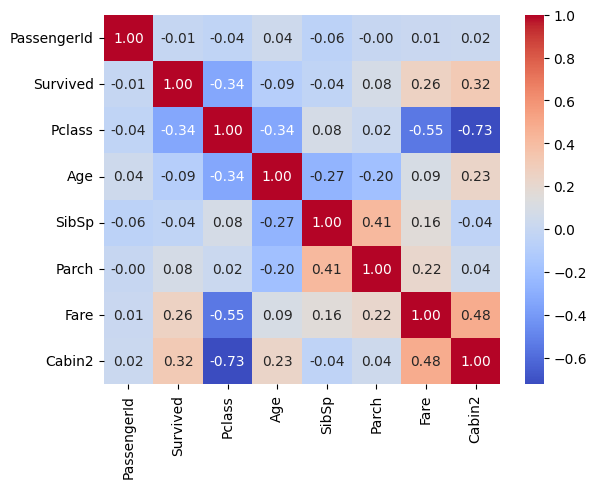

In [0]:
numeric_columns = dfp.select_dtypes(include=['int', 'float']).columns

corr = dfp[numeric_columns].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

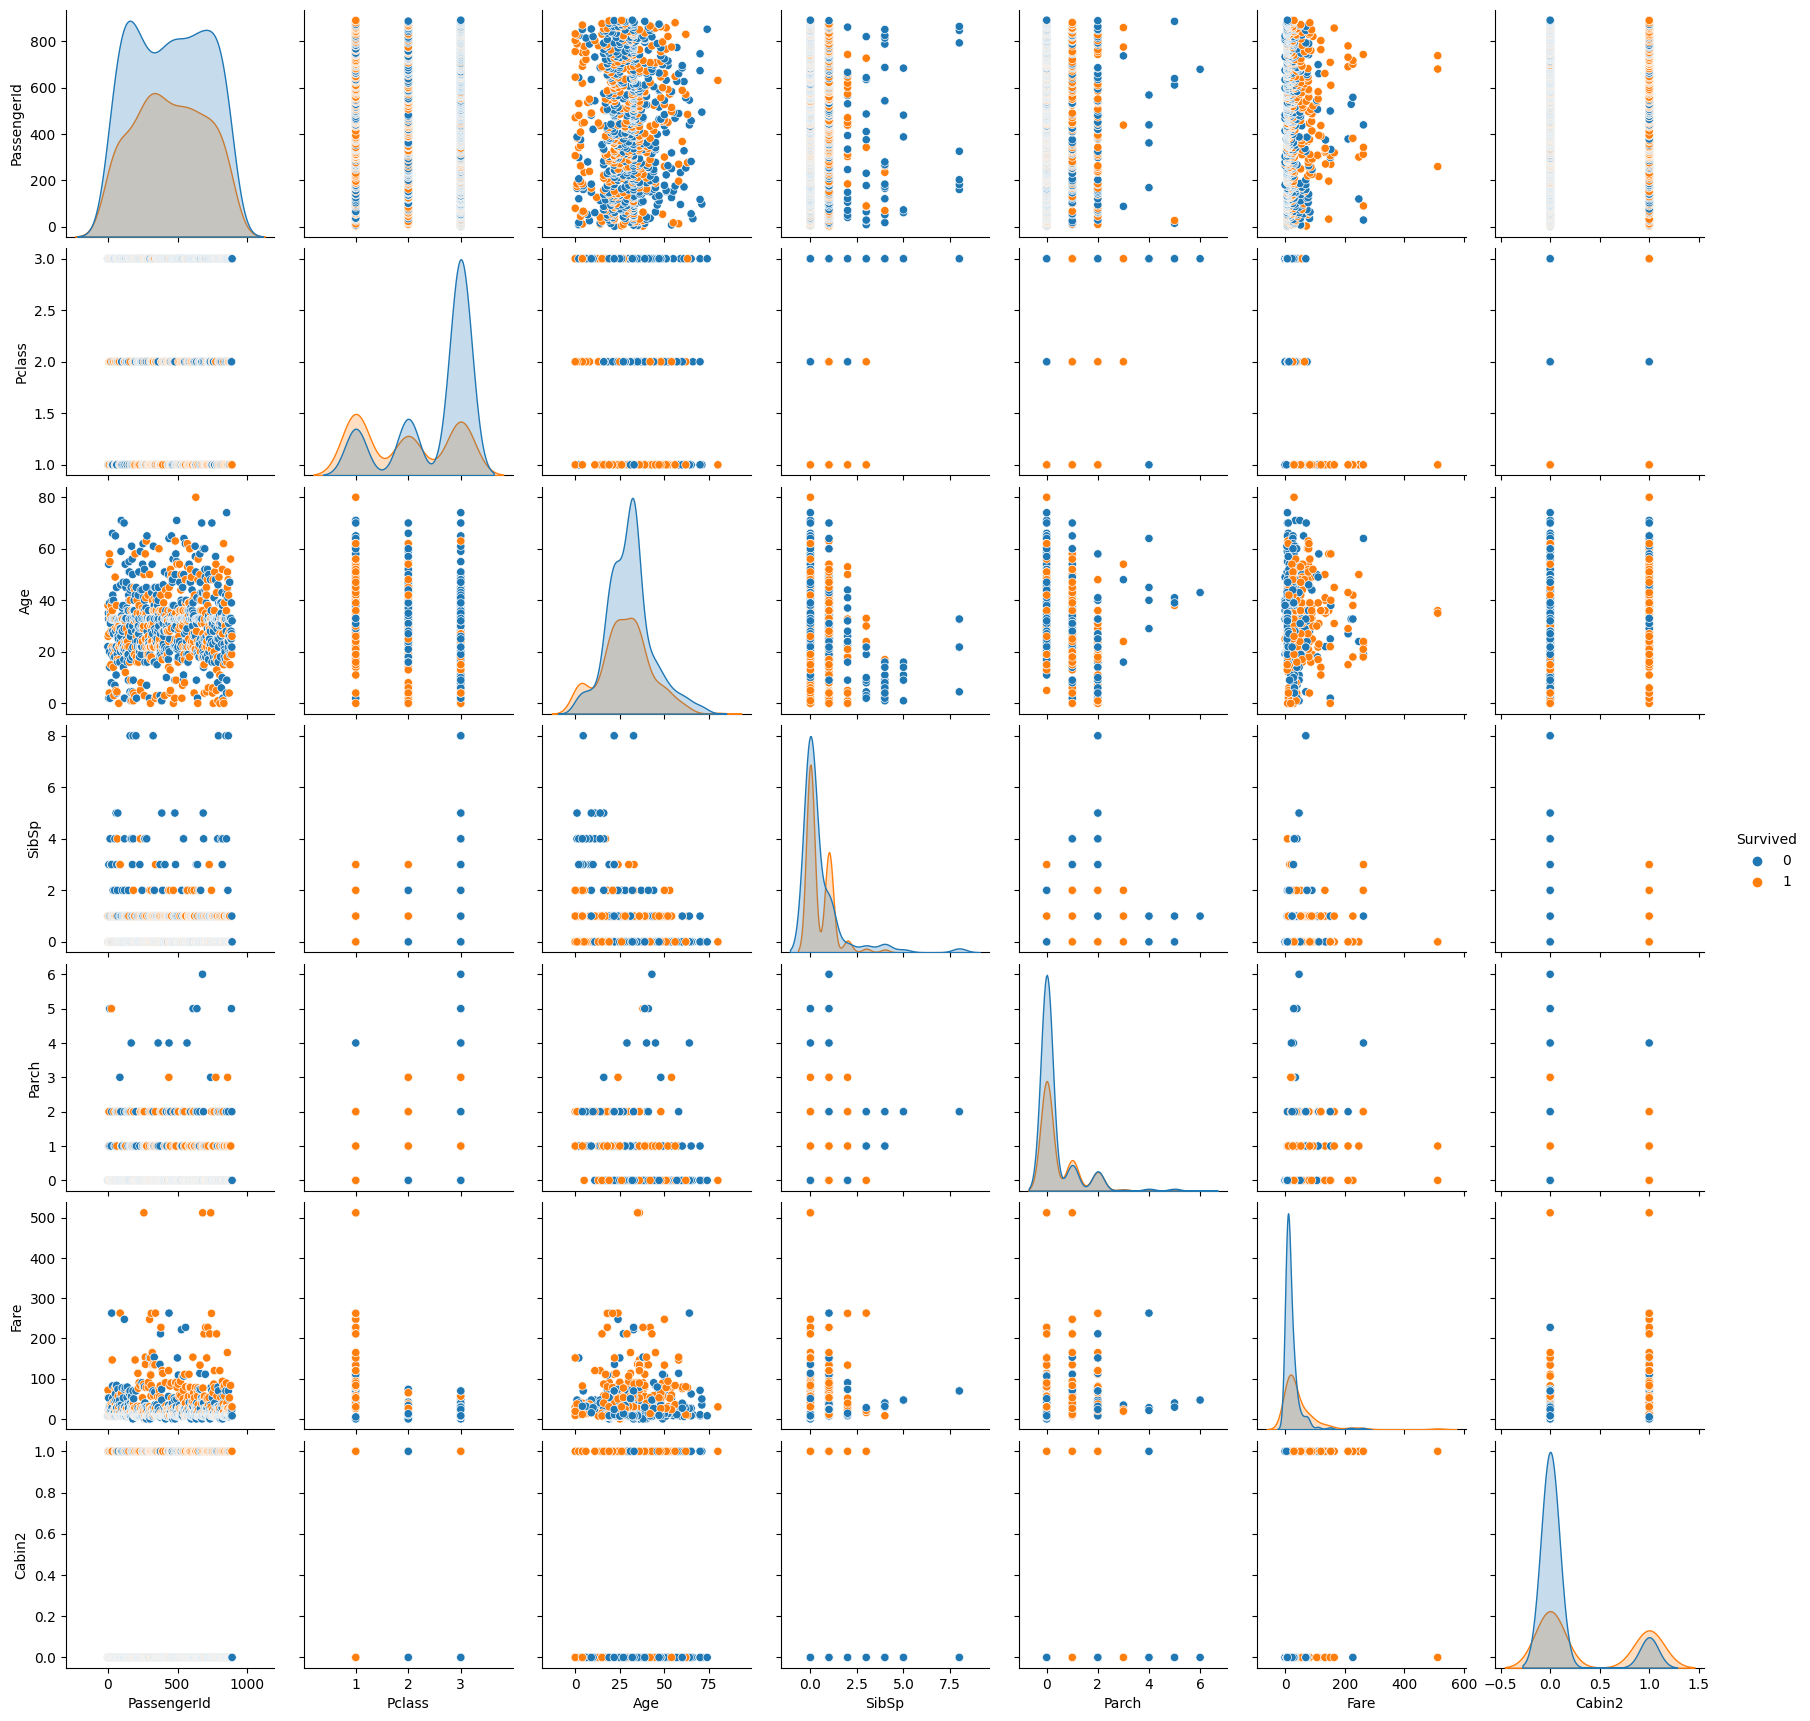

In [0]:
sns.pairplot(dfp, hue='Survived')

## 2) Modeling

### 2.1) Feature engineering

#### 2.1.1) AgeCategory

In [0]:
df = df.withColumn("AgeCategory",
    F.when(df['Age'] <= 17, 0)
    .when((df['Age'] > 17) & (df['Age'] <= 32), 1)
    .when((df['Age'] > 32) & (df['Age'] <= 48), 2)
    .when((df['Age'] > 48) & (df['Age'] <= 64), 3)
    .otherwise(4)
)

#### 2.1.2) Sex
Convert categorical features into numerical
- Sex: 
  - male = 1, 
  - female = 2

In [0]:
df = df.withColumn("Sex", when(df["Sex"] == "male", 1).otherwise(2))

#### 2.1.3) Embarked
Convert categorical features into numerical
- Embarked:
  - C = 1, 
  - Q = 2, 
  - S = 3

In [0]:
df = df.withColumn("Embarked", when(df["Embarked"] == "C", 1).when(df["Embarked"] == "Q", 2).otherwise(3))

Let's create e new df with the most important feautes

In [0]:
df2=df.drop('Name','Cabin','Ticket','Fare','Title', 'Age','Deck')

Let's see how it looks!

In [0]:
df2.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: integer (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Embarked: integer (nullable = false)
 |-- Cabin2: integer (nullable = false)
 |-- AgeCategory: integer (nullable = false)



In [0]:
df2.display()

PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Cabin2,AgeCategory
1,0,3,1,1,0,3,0,1
2,1,1,2,1,0,1,1,2
3,1,3,2,0,0,3,0,1
4,1,1,2,1,0,3,1,2
5,0,3,1,0,0,3,0,2
6,0,3,1,0,0,2,0,2
7,0,1,1,0,0,3,1,3
8,0,3,1,3,1,3,0,0
9,1,3,2,0,2,3,0,1
10,1,2,2,1,0,1,0,0


### 2.3) Models
Let's transform the features into a vector format using PySpark's VectorAssembler

In [0]:
# PySPark Libraries
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
assembler = VectorAssembler(
  inputCols = ['Pclass', 'Sex','SibSp', 'Parch' ,'Embarked', 'Cabin2','AgeCategory'],
  outputCol="features"
)

In [0]:
test_size = 0.2
test_seed = 2024
train_data, test_data = df2.randomSplit([1-test_size,test_size],seed=test_seed)

In [0]:
'''
train_data.printSchema()
train_data.display()
train_data.describe().display()
'''

'\ntrain_data.printSchema()\ntrain_data.display()\ntrain_data.describe().display()\n'

In [0]:
pipeline1 = Pipeline(stages=[assembler])

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="Survived")

def getCrossValidator(estimator, params, folds):
  return CrossValidator(
      estimator=estimator,
      estimatorParamMaps=params,
      evaluator=evaluator,
      numFolds=folds,
      seed=101
  )

#### 2.3.1) Logistic Regression

In [0]:
lr = LogisticRegression(
    featuresCol="features", 
    labelCol="Survived"
)

lr_hp_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

pipeline_lr = Pipeline(stages=[pipeline1, getCrossValidator(lr, lr_hp_grid, 5)])

model_lr = pipeline_lr.fit(train_data)

# best model
best_lr_model = model_lr.stages[-1].bestModel
print(best_lr_model._java_obj)
print("Best regularization parameter (regParam):", best_lr_model._java_obj.getRegParam())
print("Best elastic net parameter (elasticNetParam):", best_lr_model._java_obj.getElasticNetParam())

LogisticRegressionModel: uid=LogisticRegression_ff73d064c365, numClasses=2, numFeatures=7
Best regularization parameter (regParam): 0.1
Best elastic net parameter (elasticNetParam): 0.0


In [0]:
# lr with best parameters
best_lr_model = LogisticRegression(
    featuresCol="features", 
    labelCol="Survived",
    regParam=best_lr_model._java_obj.getRegParam(),
    elasticNetParam=best_lr_model._java_obj.getElasticNetParam()
)

pipeline_best_lr = Pipeline(stages=[pipeline1, best_lr_model])

model1 = pipeline_best_lr.fit(train_data)

#### 2.3.2) MLP

In [0]:
mlp = MultilayerPerceptronClassifier(
    #maxIter=100
    layers=[7,2], #change the number of input in relation to how many features
    labelCol="Survived"
)

mlp_hp_grid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100]) \
    .addGrid(mlp.stepSize, [0.03, 0.1]) \
    .build()

pipeline_mlp = Pipeline(stages=[pipeline1, getCrossValidator(mlp, mlp_hp_grid, 5)])

model_mlp = pipeline_mlp.fit(train_data)

# best model
best_perc_model = model_mlp.stages[-1].bestModel
print("Best max iteration:", best_perc_model.getMaxIter())
print("Best step size:", best_perc_model.getStepSize())

Best max iteration: 50
Best step size: 0.03


In [0]:
best_pipeline_perc = Pipeline(stages=[pipeline1, best_perc_model])
model2 = best_pipeline_perc.fit(train_data)

#### 2.3.3) Random Forest

In [0]:
rf = RandomForestClassifier(
    labelCol="Survived"
)

rf_hp_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

pipeline_rf = Pipeline(stages=[pipeline1, getCrossValidator(rf, rf_hp_grid, 5)])

model_rf = pipeline_rf.fit(train_data)

# best model
best_rf_model = model_rf.stages[-1].bestModel
print("Best number of trees:", best_rf_model.getNumTrees)
print("Best max depth:", best_rf_model.getMaxDepth())

Best number of trees: 10
Best max depth: 5


In [0]:
best_pipeline_rf = Pipeline(stages=[pipeline1, best_rf_model])
model3 = best_pipeline_rf.fit(train_data)

### 2.4) Models comparison

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="Survived")

models = [model1, model2, model3]
model_names = ["LR", "MLP", "RF"]

for i in range(len(models)):
    predictionsTrain = models[i].transform(train_data)
    auc_train = evaluator.evaluate(predictionsTrain)
    print(model_names[i])
    print("AUC (train set): ", auc_train)

    predictionsTest = models[i].transform(test_data)
    auc_test = evaluator.evaluate(predictionsTest)
    print("AUC (test set): ", auc_test)

    accuracy = MulticlassClassificationEvaluator(labelCol='Survived', metricName='accuracy').evaluate(predictionsTest)
    precision = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision').evaluate(predictionsTest)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('-----')

LR
AUC (train set):  0.8616277420377647
AUC (test set):  0.8639657444005271
Accuracy:  0.7877094972067039
Precision:  0.7855537514562749
-----
MLP
AUC (train set):  0.7590135756422772
AUC (test set):  0.7373517786561267
Accuracy:  0.7932960893854749
Precision:  0.7914136507165412
-----
RF
AUC (train set):  0.8740978080385826
AUC (test set):  0.843939393939394
Accuracy:  0.7877094972067039
Precision:  0.7870443486950967
-----


Random Foreset resulted the best model

### 2.5) Evaluation

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
predictions = model3.transform(test_data)
class_temp = predictions\
    .select("Survived")\
    .groupBy("Survived")\
    .count()\
    .sort('count', ascending=False)\
    .toPandas()

class_temp = class_temp["Survived"].values.tolist()

In [0]:
predictions.printSchema()

In [0]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("Survived")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

In [0]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, 
    classes=["0", "1"],
    title='Confusion matrix, without normalization'
)

plt.show()

In [0]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, 
    classes=["0", "1"], 
    normalize=True,
    title='Normalized confusion matrix'
)

plt.show()

## 3) Conclusion